In [25]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
def decompose(signal, signals):
    # assumes signals are orthonormalized
    return torch.tensor([torch.tensor(signal).dot(torch.tensor(h)) for h in signals])

In [3]:
def num_needed_for_rat(nums, rat = 0.5):
    # returns the number of elements needed to reach at least `rat` of the sum of the input list
    total = sum(nums)
    targ = total * rat
    running_sum = 0
    for i, num in enumerate(sorted(nums, reverse=True)):
        running_sum += num
        if running_sum >= targ:
            return i + 1
    return len(nums)

In [4]:
df = pd.read_csv('data/zinc_test_rec.csv', index_col=1)
df.sort_index(inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
def lapFromInfo(edge_index, num_nodes):
    laplacian = torch.zeros((num_nodes, num_nodes), dtype=torch.float64)
    for i,j in zip(*edge_index):
        laplacian[i, j] = -1
        laplacian[j, i] = -1
        laplacian[i, i] += 1
        laplacian[j, j] += 1
    return laplacian

In [20]:
def getNormFracs(edge_index, num_nodes, signals, fracs = [0.25, 0.5, 0.75]):
    
    # get graph spectrum info
    laplacian = lapFromInfo(edge_index, num_nodes)
    eigvals, eigvecs = torch.eig(laplacian, eigenvectors=True)
    eigvals = eigvals[:, 0]  # take the real part of eigenvalues
    sorted_indices = torch.argsort(eigvals)
    eigvecs_sorted = eigvecs[:, sorted_indices]
    eigvals_sorted = eigvals[sorted_indices]
    eigvec_list = [eigvecs_sorted[:, i] for i in range(eigvecs_sorted.shape[1])]
    
    # get decompositions
    decompositions = [torch.abs(decompose(eigvec, signals)) for eigvec in eigvec_list]
    
    # get percentage of components needed for each L2 norm fraction
    component_amt = []
    for frac in fracs:
        component_amt.append(np.mean([num_needed_for_rat(decomp ** 2, frac) / len(decomp) for decomp in decompositions]))
    return component_amt

In [21]:
def normalize_vectors(vectors):
    normed = []
    for v in torch.tensor(vectors, dtype=torch.float64):
        normed.append(v / torch.norm(v))
    return torch.stack(normed)

In [22]:
def batch_sort(items, keys):
    # Sort the dyadic-power-delimited chunks
    sorted_items = [item for item in items]
    i = 1
    while i < 2*len(keys):
        sorted_indices = sorted(list(range(i//2, i)), key=lambda x: keys[x])
        sorted_items[i//2:i] = [sorted_items[idx] for idx in sorted_indices]
        i *= 2
    return sorted_items

In [23]:
def energies(vecs, lap): # vectors should be row-wise in a tensor
    return [x.item() for x in torch.diag(vecs @ lap @ vecs.T)]

In [26]:
normFracs = []
for i in tqdm(range(df.shape[0])):
    signals = eval(df.signals[i])
    num_nodes = df.num_nodes[i]
    edge_index = eval(df.edge_index[i])
    
    signals = normalize_vectors(signals) 
    laplacian = lapFromInfo(edge_index, num_nodes)
    energ = energies(signals, laplacian)
    signals = batch_sort(signals, energ)
    normFracs.append(getNormFracs(edge_index, num_nodes, signals, [0.25,.5,.75]))

  0%|          | 0/1000 [00:00<?, ?it/s]/home/bsw38/.conda/envs/benchmark_gnn_2/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 1000/1000 [01:00<00:00, 16.65it/s]


In [28]:
normFracs = np.array(normFracs).T # each row corresponds to a different fraction

In [30]:
# Plot the cumulative distributions
normFracs.sort(axis=1)

In [32]:
normFracs_sorted = normFracs

In [33]:
normFracs_sorted

array([[0.04241071, 0.04545455, 0.04592803, ..., 0.09166667, 0.09583333,
        0.09615385],
       [0.09090909, 0.0953125 , 0.09926471, ..., 0.16666667, 0.171875  ,
        0.17708333],
       [0.19117647, 0.19460227, 0.19852941, ..., 0.2890625 , 0.29166667,
        0.29296875]])

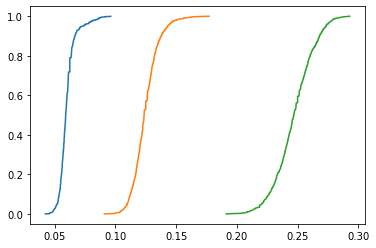

In [35]:
# Plot a cumulative distribution curve for each fraction
for row in normFracs_sorted:
    plt.plot(row, np.linspace(0, 1, len(row)))